<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Evaluation-of-TPC-H-Data-Generation---Pods-synched" data-toc-modified-id="Evaluation-of-TPC-H-Data-Generation---Pods-synched-1">Evaluation of TPC-H Data Generation - Pods synched</a></span><ul class="toc-item"><li><span><a href="#Import-some-libraries" data-toc-modified-id="Import-some-libraries-1.1">Import some libraries</a></span></li></ul></li><li><span><a href="#Load-Results" data-toc-modified-id="Load-Results-2">Load Results</a></span><ul class="toc-item"><li><span><a href="#Load-Results-and-Generate-Common-DataFrame" data-toc-modified-id="Load-Results-and-Generate-Common-DataFrame-2.1">Load Results and Generate Common DataFrame</a></span></li><li><span><a href="#Results-in-Format-&quot;time&quot;" data-toc-modified-id="Results-in-Format-&quot;time&quot;-2.2">Results in Format "time"</a></span></li><li><span><a href="#Results-in-Format-&quot;Throughput&quot;" data-toc-modified-id="Results-in-Format-&quot;Throughput&quot;-2.3">Results in Format "Throughput"</a></span></li></ul></li><li><span><a href="#Data-Generation-Phase" data-toc-modified-id="Data-Generation-Phase-3">Data Generation Phase</a></span><ul class="toc-item"><li><span><a href="#Plot-Throughput" data-toc-modified-id="Plot-Throughput-3.1">Plot Throughput</a></span></li><li><span><a href="#Plot-Time" data-toc-modified-id="Plot-Time-3.2">Plot Time</a></span></li><li><span><a href="#Plot-Variation" data-toc-modified-id="Plot-Variation-3.3">Plot Variation</a></span></li><li><span><a href="#Plot-Hardware-Metrics" data-toc-modified-id="Plot-Hardware-Metrics-3.4">Plot Hardware Metrics</a></span></li></ul></li></ul></div>

# Evaluation of TPC-H Data Generation - Pods synched

<img src="https://raw.githubusercontent.com/Beuth-Erdelt/Benchmark-Experiment-Host-Manager/master/docs/workflow-sketch-simple.png"/>

`MonetDB-NIL` is just a placeholder for no DBMS (data is not ingested, but only generated to disk)

## Import some libraries

In [1]:
from dbmsbenchmarker import *
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)

# Some plotly figures
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

# Some nice output
from IPython.display import display, Markdown

import logging
logging.basicConfig(level=logging.INFO)


import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [2]:
# path of folder containing experiment results
resultfolder = "./"

# create evaluation object for result folder
evaluate = inspector.inspector(resultfolder)

# list of experiments to be combined
codes = [1686982716, 1687009029, 1686985086, 1687009047, 1686985110]

# Load Results

In [3]:
import ast
import json
import statistics
import pandas as pd

def generate_df(code):
    global SF, dbms, imported, portion_of_data
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    # loading
    evaluate.load_experiment(code)
    df = evaluate.get_loading_metrics('total_cpu_memory')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory = df[0]
    df = evaluate.get_loading_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu = df[0]
    # benchmarking
    df = evaluate.get_streaming_metrics('total_cpu_memory')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory_stream = df[0]
    df = evaluate.get_streaming_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu_stream = df[0]
    # data generator
    df = evaluate.get_datagenerator_metrics('total_cpu_memory')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory_datagenerator = df[0]
    #print(hw_memory_datagenerator)
    df = evaluate.get_datagenerator_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu_datagenerator = df[0]
    # loader
    df = evaluate.get_loader_metrics('total_cpu_memory')
    df = df.T.max().sort_index()
    df = pd.DataFrame(df)
    hw_memory_loader = df[0]
    df = evaluate.get_loader_metrics('total_cpu_util_s')
    df = df.T.max().sort_index() - df.T.min().sort_index()
    df = pd.DataFrame(df)
    hw_cpu_loader = df[0]
    # benchmark
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Mean', total_aggregate='Mean')
    df_mean = (df/1000.0).sort_index()
    #print(df_mean)
    df = evaluate.get_aggregated_experiment_statistics(type='timer', name='run', query_aggregate='Median', total_aggregate='Geo')
    df_geo = (df/1000.0).sort_index()
    #print(df_geo)
    #df_metric[0]['PostgreSQL-BHT-1-1-1']
    #df_metric.plot()
    #pretty_connections = json.dumps(connections, indent=2)
    df_merged_time = pd.DataFrame()
    df_merged_tpx = pd.DataFrame()
    for c in connections_sorted:
        #print(c)
        connection_name = c['name']
        orig_name = c['orig_name']
        #print(connection_name, orig_name)
        properties = evaluate.get_experiment_connection_properties(connection_name)
        dbms = properties['docker']
        #print(properties)
        # load
        if orig_name in hw_cpu:
            hw_cpu_c = hw_cpu[orig_name]
        else:
            hw_cpu_c = 0
        if orig_name in hw_memory:
            hw_memory_c = hw_memory[orig_name]
        else:
            hw_memory_c = 0
        # stream
        if connection_name in hw_cpu_stream:
            hw_cpu_stream_c = hw_cpu_stream[connection_name]
        else:
            hw_cpu_stream_c = 0
        if connection_name in hw_memory_stream:
            hw_memory_stream_c = hw_memory_stream[connection_name]
        else:
            hw_memory_stream_c = 0
        # loader
        if orig_name in hw_cpu_loader:
            hw_cpu_loader_c = hw_cpu_loader[orig_name]
        else:
            hw_cpu_loader_c = 0
        if orig_name in hw_memory_loader:
            hw_memory_loader_c = hw_memory_loader[orig_name]
        else:
            hw_memory_loader_c = 0
        # data generator
        if orig_name in hw_cpu_datagenerator:
            hw_cpu_datagenerator_c = hw_cpu_datagenerator[orig_name]
        else:
            hw_cpu_datagenerator_c = 0
        if orig_name in hw_memory_datagenerator:
            hw_memory_datagenerator_c = hw_memory_datagenerator[orig_name]
        else:
            hw_memory_datagenerator_c = 0
        results = dict()
        eva = evaluate.get_experiment_connection_properties(c['name'])
        SF = int(c['parameter']['connection_parameter']['loading_parameters']['SF'])
        if 'TPCH_TABLE' in c['parameter']['connection_parameter']['loading_parameters']:
            TPCH_TABLE = c['parameter']['connection_parameter']['loading_parameters']['TPCH_TABLE']
        else:
            TPCH_TABLE = ''
        imported = TPCH_TABLE
        #if len(c['hostsystem']['loading_timespans']['sensor']) == 0:
        #    continue
        #timespan_load = max([end for (start,end) in c['hostsystem']['loading_timespans']['sensor']]) - min([start for (start,end) in c['hostsystem']['loading_timespans']['sensor']])
        timespan_datagenerate = max([end for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']]) - min([start for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']])
        timespan_benchmark = eva['times']['total'][c['name']]['time_end']-eva['times']['total'][c['name']]['time_start']
        results[connection_name] = {
            'load':eva['times']['load_ms']/1000.,
            'ingest':eva['times']['ingest_ms']/1000.,
            'generate':eva['times']['generate_ms']/1000.,
            'schema':eva['times']['schema_ms']/1000.,
            #'index':eva['times']['index_ms']/1000.,
            'loaded':eva['times']['script_times']['loaded'],
            'initschema':eva['times']['script_times']['initschema'],
            'span_load':0,#timespan_load,
            'span_benchmark':timespan_benchmark,
            'mean_generate': statistics.mean([end-start for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']]),
            'max_generate': max([end-start for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']]),
            'min_generate': min([end-start for (start,end) in c['hostsystem']['loading_timespans']['datagenerator']]),
            #'mean_load': statistics.mean([end-start for (start,end) in c['hostsystem']['loading_timespans']['sensor']]),
            #'max_load': max([end-start for (start,end) in c['hostsystem']['loading_timespans']['sensor']]),
            #'min_load': min([end-start for (start,end) in c['hostsystem']['loading_timespans']['sensor']]),
            'span_generate': timespan_datagenerate,#c['timeGenerate'],
            #'pods': int(c['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL']),
            #'indexed':eva['times']['script_times']['indexed'],
            'initindexes':0,#eva['times']['script_times']['initindexes'],
            'initconstraints':0,#eva['times']['script_times']['initconstraints'],
            'initstatistics':0,#eva['times']['script_times']['initstatistics'],
            'benchmark_mean':df_mean.loc[connection_name]['total_timer_run'],
            'benchmark_geo':df_geo.loc[connection_name]['total_timer_run'],
        }
        # DataFrame of time
        df = pd.DataFrame(results).T
        df_time = df.copy()
        df_tpx = df.copy()
        # Compute DataFrame of throughput (Tpx)
        df_tpx = 3600*int(SF)/df_tpx * portion_of_data
        # Set Values that are same for time and tpx
        df_time['SF'] = int(SF)
        df_tpx['SF'] = int(SF)
        df_time['dbms'] = dbms
        df_tpx['dbms'] = dbms
        df_time['TPCH_TABLE'] = TPCH_TABLE
        df_tpx['TPCH_TABLE'] = TPCH_TABLE
        df_time['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PARALLEL'])
        df_tpx['pods'] = int(c['parameter']['connection_parameter']['loading_parameters']['PARALLEL'])
        #df_time['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        #df_tpx['threads'] = int(c['parameter']['connection_parameter']['loading_parameters']['MYSQL_LOADING_THREADS'])
        df_time['num_experiment'] = int(c['parameter']['numExperiment'])
        df_tpx['num_experiment'] = int(c['parameter']['numExperiment'])
        df_time['num_client'] = int(c['parameter']['client'])
        df_tpx['num_client'] = int(c['parameter']['client'])
        df_time['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_time['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        df_tpx['benchmark_start'] = eva['times']['total'][c['name']]['time_start']
        df_tpx['benchmark_end'] = eva['times']['total'][c['name']]['time_end']
        # load
        df_time['mem_max_load'] = hw_memory_c
        df_tpx['mem_max_load'] = hw_memory_c
        df_time['cpu_total_load'] = hw_cpu_c
        df_tpx['cpu_total_load'] = hw_cpu_c
        # stream
        df_time['mem_max_stream'] = hw_memory_stream_c
        df_tpx['mem_max_stream'] = hw_memory_stream_c
        df_time['cpu_total_stream'] = hw_cpu_stream_c
        df_tpx['cpu_total_stream'] = hw_cpu_stream_c
        # loader
        df_time['mem_max_loader'] = hw_memory_loader_c
        df_tpx['mem_max_loader'] = hw_memory_loader_c
        df_time['cpu_total_loader'] = hw_cpu_loader_c
        df_tpx['cpu_total_loader'] = hw_cpu_loader_c
        # data generator
        df_time['mem_max_datagenerator'] = hw_memory_datagenerator_c
        df_tpx['mem_max_datagenerator'] = hw_memory_datagenerator_c
        df_time['cpu_total_datagenerator'] = hw_cpu_datagenerator_c
        df_tpx['cpu_total_datagenerator'] = hw_cpu_datagenerator_c
        df_merged_time = pd.concat([df_merged_time, df_time])
        df_merged_tpx = pd.concat([df_merged_tpx, df_tpx])
    return df_merged_time, df_merged_tpx

def merge_experiments(df_time, df_tpx, code):
    df_time_tmp, df_tpx_tmp = generate_df(code)
    df_time = pd.concat([df_time, df_time_tmp])
    df_tpx = pd.concat([df_tpx, df_tpx_tmp])
    return df_time, df_tpx

## Load Results and Generate Common DataFrame

In [4]:
df_time = pd.DataFrame()
df_tpx = pd.DataFrame()

portion_of_data = 1.0 # for lineitem table = 0.7, for all tables = 1.0

for code in codes:
    df_time, df_tpx = merge_experiments(df_time, df_tpx, code)

Results in folder .//1686982716
Read results
Load Evaluation
Results in folder .//1687009029
Read results
Load Evaluation
Results in folder .//1686985086
Read results
Load Evaluation
Results in folder .//1687009047
Read results
Load Evaluation
Results in folder .//1686985110
Read results
Load Evaluation


## Results in Format "time"

In [5]:
df_time.T

,MonetDB-NIL-1-1-1,MonetDB-NIL-16-1-1,MonetDB-NIL-2-1-1,MonetDB-NIL-24-1-1,MonetDB-NIL-4-1-1,MonetDB-NIL-8-1-1,MonetDB-NIL-1-1-1,MonetDB-NIL-16-1-1,MonetDB-NIL-2-1-1,MonetDB-NIL-24-1-1,...,MonetDB-NIL-2-1-1,MonetDB-NIL-24-1-1,MonetDB-NIL-4-1-1,MonetDB-NIL-8-1-1,MonetDB-NIL-1-1-1,MonetDB-NIL-16-1-1,MonetDB-NIL-2-1-1,MonetDB-NIL-24-1-1,MonetDB-NIL-4-1-1,MonetDB-NIL-8-1-1
benchmark_geo,0.02518,0.024054,0.028954,0.023791,0.030548,0.084998,0.023613,0.030398,0.023268,0.028397,...,0.031774,0.03163,0.023597,0.025067,0.031594,0.033425,0.02893,0.084473,0.031608,0.023893
benchmark_mean,0.02518,0.024054,0.028954,0.023791,0.030548,0.084998,0.023613,0.030398,0.023268,0.028397,...,0.031774,0.03163,0.023597,0.025067,0.031594,0.033425,0.02893,0.084473,0.031608,0.023893
generate,20.0,10.0,13.0,14.0,9.0,7.0,51.0,13.0,28.0,18.0,...,237.0,65.0,124.0,94.0,1409.0,262.0,780.0,211.0,421.0,316.0
ingest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
initconstraints,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
initindexes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
initschema,2.14621,2.221648,2.219303,2.221781,2.29246,1.955046,2.241456,1.969995,2.32202,2.039701,...,2.259004,2.195535,2.154405,2.235312,2.265733,2.245372,2.162388,2.148655,2.200167,2.25848
initstatistics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
load,23.181873,13.100281,16.188025,17.268866,12.192802,9.908228,54.316011,15.960496,31.397268,20.984719,...,240.318125,68.263856,127.263614,97.272613,1412.318122,265.287458,783.207565,214.054739,424.300336,319.296462
loaded,3.181873,3.100281,3.188025,3.268866,3.192802,2.908228,3.316011,2.960496,3.397268,2.984719,...,3.318125,3.263856,3.263614,3.272613,3.318122,3.287458,3.207565,3.054739,3.300336,3.296462


## Results in Format "Throughput"

In [6]:
df_tpx.T

,MonetDB-NIL-1-1-1,MonetDB-NIL-16-1-1,MonetDB-NIL-2-1-1,MonetDB-NIL-24-1-1,MonetDB-NIL-4-1-1,MonetDB-NIL-8-1-1,MonetDB-NIL-1-1-1,MonetDB-NIL-16-1-1,MonetDB-NIL-2-1-1,MonetDB-NIL-24-1-1,...,MonetDB-NIL-2-1-1,MonetDB-NIL-24-1-1,MonetDB-NIL-4-1-1,MonetDB-NIL-8-1-1,MonetDB-NIL-1-1-1,MonetDB-NIL-16-1-1,MonetDB-NIL-2-1-1,MonetDB-NIL-24-1-1,MonetDB-NIL-4-1-1,MonetDB-NIL-8-1-1
benchmark_geo,142969.373903,149665.422859,124335.912398,151319.232642,117847.268261,42354.005999,457377.247022,355290.155405,464151.31632,380318.998868,...,3398957.552518,3414487.156762,4576756.013073,4308465.203859,11394736.655727,10770401.425703,12443703.904416,4261715.701687,11389692.078528,15067275.38952
benchmark_mean,142969.373903,149665.422859,124335.912398,151319.232642,117847.268261,42354.005999,457377.247022,355290.155405,464151.31632,380318.998868,...,3398957.552518,3414487.156762,4576756.013073,4308465.203859,11394736.655727,10770401.425703,12443703.904416,4261715.701687,11389692.078528,15067275.38952
generate,180.0,360.0,276.923077,257.142857,400.0,514.285714,211.764706,830.769231,385.714286,600.0,...,455.696203,1661.538462,870.967742,1148.93617,255.500355,1374.045802,461.538462,1706.161137,855.106888,1139.240506
ingest,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
initconstraints,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
initindexes,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
initschema,1677.375307,1620.418355,1622.130741,1620.321903,1570.365607,1841.388621,4818.297203,5482.246721,4651.121978,5294.893401,...,47808.680564,49190.732852,50129.856171,48315.400245,158888.988247,160329.750126,166482.62313,167546.665504,163623.924499,159399.240492
initstatistics,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
load,155.293751,274.803272,222.386608,208.467659,295.256179,363.334408,198.836399,676.670694,343.978969,514.66022,...,449.404305,1582.096396,848.632193,1110.281673,254.900078,1357.018543,459.648267,1681.812801,848.455608,1127.478827
loaded,1131.409098,1161.185175,1129.225734,1101.299464,1127.536414,1237.867366,3256.925398,3648.037169,3179.024666,3618.431322,...,32548.5007,33089.698794,33092.14685,33001.147974,108495.100944,109507.093719,112234.671519,117849.680826,109079.792605,109208.007478


# Data Generation Phase

## Plot Throughput

SF,1,3,10,30,100
pods,,,,,
1,180.000000,211.764706,227.848101,231.759657,255.500355
2,276.923077,385.714286,428.571429,455.696203,461.538462
4,400.000000,635.294118,800.000000,870.967742,855.106888
8,514.285714,981.818182,1000.000000,1148.936170,1139.240506
16,360.000000,830.769231,1161.290323,1421.052632,1374.045802
24,257.142857,600.000000,1058.823529,1661.538462,1706.161137


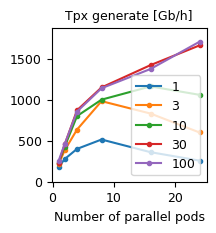

In [7]:
%matplotlib inline

df_tpx = df_tpx.astype({'pods':'int', 'span_generate': 'float'})

df_tpx_pivot = df_tpx.pivot(index='pods', columns='SF', values='span_generate')

df_tpx_pivot.plot(style='.-', title='PostgreSQL Tpx ingest from Disk [Gb/h]', figsize=(2,2), fontsize=9)#, logx=True)
plt.legend(fontsize=9)
plt.xlabel('Number of parallel pods', fontsize=9)
plt.ylim(0, df_tpx_pivot.max().max()*1.1)
plt.title("Tpx generate [Gb/h]".format(dbms=dbms, imported=imported), fontsize=9)

df_tpx_pivot


## Plot Time

SF,1,3,10,30,100
pods,,,,,
1,20.0,51.0,158.0,466.0,1409.0
2,13.0,28.0,84.0,237.0,780.0
4,9.0,17.0,45.0,124.0,421.0
8,7.0,11.0,36.0,94.0,316.0
16,10.0,13.0,31.0,76.0,262.0
24,14.0,18.0,34.0,65.0,211.0


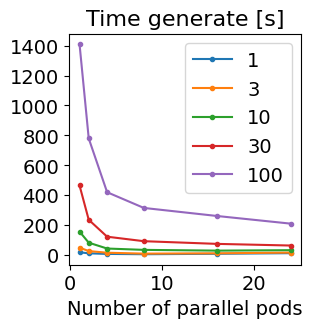

In [8]:
%matplotlib inline

df_time = df_time.astype({'pods':'int', 'span_generate': 'float'})

df_time_pivot = df_time.pivot(index='pods', columns='SF', values='span_generate')

df_time_pivot.plot(style='.-', title='Time generate [s]'.format(SF=SF), figsize=(3,3), fontsize=14)#, logx=True)
plt.legend(fontsize=14)
plt.xlabel('Number of parallel pods', fontsize=14)
plt.title("Time generate [s]".format(dbms=dbms, imported=imported), fontsize=16)

df_time_pivot

## Plot Variation

(0.0, 1876.7772511848343)

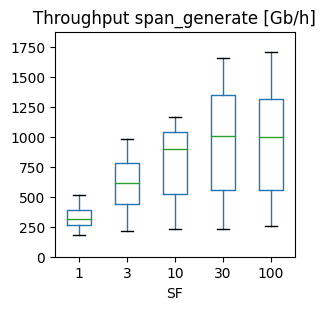

In [9]:
import matplotlib.pyplot as plt

column = 'span_generate'
df_tpx.boxplot(column=column, by='SF', figsize=(3,3), grid=False)
plt.title('Throughput '+column+' [Gb/h]')
plt.suptitle('')
plt.ylim(0, df_tpx[column].max()*1.1)

## Plot Hardware Metrics

In [10]:
df_res = pd.DataFrame()
for code in codes:
    evaluate.load_experiment(code)
    df = evaluate.get_datagenerator_metrics('total_cpu_memory').T.max()
    df = df.reindex(index=natural_sort(df.index))
    path=resultfolder
    with open(path+str(code)+"/connections.config",'r') as inf:
        connections = ast.literal_eval(inf.read())
    #print("found", len(connections), "connections")
    connections_sorted = sorted(connections, key=lambda c: c['name'])
    SF = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['SF']
    pods = connections_sorted[0]['parameter']['connection_parameter']['loading_parameters']['PODS_PARALLEL']
    #print(df)
    df.index = df.index.map(lambda x: int(x[len('MonetDB-NIL-'):-2]))
    #print(df)
    df_res[int(SF)] = df.copy()/1000#/int(SF)
    #df.T.max().plot.bar()

#print(df_res)

Results in folder .//1686982716
Read results
Load Evaluation
Results in folder .//1687009029
Read results
Load Evaluation
Results in folder .//1686985086
Read results
Load Evaluation
Results in folder .//1687009047
Read results
Load Evaluation
Results in folder .//1686985110
Read results
Load Evaluation


,1,3,10,30,100
DBMS,,,,,
1,0.305215,0.309590,0.326625,0.375090,0.548668
2,0.521184,0.611629,0.630090,0.679176,0.852207
4,0.487574,1.216559,1.234500,1.279824,1.455168
8,0.610977,2.429219,2.441605,2.491781,2.667793
16,2.022078,4.853973,4.867820,4.913684,5.095398
24,3.810734,5.315609,7.291055,7.335469,7.516445


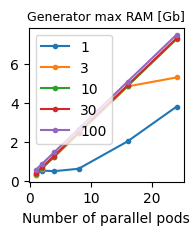

In [11]:
ax = df_res.plot(figsize=(2,2), grid=False, style=".-")
plt.title('Generator max RAM [Gb]'.format(dbms), fontsize=9)
plt.suptitle('')
ax.set_xlabel("Number of parallel pods")
#ax.set_xticks(range(0,8))
#plt.legend(title='SF')
df_res